# Instance Segmentation demo to detect cans with AutoML for Images

## Environment Setup
> Please follow the ["Setup a new conda environment"](https://github.com/Azure/azureml-examples/tree/main/python-sdk/tutorials/automl-with-azureml#3-setup-a-new-conda-environment) instructions to get started.

In [1]:
import azureml.core
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import requests
import matplotlib.image as mpimg
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from PIL import Image
import numpy as np
import json
import uuid
from IPython.display import display_javascript, display_html, display

In [2]:
import sys
sys.version

'3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) \n[GCC 7.3.0]'

In [3]:
#Version
import azureml.core
print("Azure ML version:", azureml.core.VERSION)

Azure ML version: 1.35.0


In [4]:
now = datetime.datetime.now()
print("Today:", now)

Today: 2021-12-10 15:16:25.279965


## Workspace setup
In order to train and deploy models in Azure ML, you will first need to set up a workspace.

An [Azure ML Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#workspace) is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows. In particular, an Azure ML Workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, deployment, inference, and the monitoring of deployed models.

Create an Azure ML Workspace within your Azure subscription or load an existing workspace.

In [6]:
from azureml.core.workspace import Workspace
ws = Workspace.from_config()
ws.name

'azuremlvision'

## Compute target setup
You will need to provide a [Compute Target](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#computes) that will be used for your AutoML model training. AutoML models for image tasks require [GPU SKUs](https://docs.microsoft.com/en-us/azure/virtual-machines/sizes-gpu) such as the ones from the NC, NCv2, NCv3, ND, NDv2 and NCasT4 series. We recommend using the NCsv3-series (with v100 GPUs) for faster training. Using a compute target with a multi-GPU VM SKU will leverage the multiple GPUs to speed up training. Additionally, setting up a compute target with multiple nodes will allow for faster model training by leveraging parallelism, when tuning hyperparameters for your model.

In [7]:
from azureml.core.compute import AmlCompute, ComputeTarget

cluster_name = "AutoML-NC6GPU"

t1 = datetime.datetime.now()

try:
    compute_target = ws.compute_targets[cluster_name]
    print("Found existing compute target.")

except KeyError:
    print("Creating a new compute target...")
    compute_config = AmlCompute.provisioning_configuration(
        vm_size="Standard_NC6",
        idle_seconds_before_scaledown=1800,
        min_nodes=0,
        max_nodes=4,
    )
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

compute_target.wait_for_completion(
    show_output=True, min_node_count=None, timeout_in_minutes=20
)

t2 = datetime.datetime.now()
print("\nTime:", t2 - t1)

Creating a new compute target...
InProgress.....
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned

Time: 0:00:27.841962


## Experiment Setup
Create an [Experiment](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#experiments) in your workspace to track your model training runs

In [8]:
from azureml.core import Experiment
experiment_name = "AutoML-InstanceSegmentation-CansDetection"
experiment = Experiment(ws, name=experiment_name)

## Dataset with input Training Data

In order to generate models for computer vision, you will need to bring in labeled image data as input for model training in the form of an [AzureML Tabular Dataset](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.data.tabulardataset). You can either use a dataset that you have exported from a [Data Labeling](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-label-data) project, or create a new Tabular Dataset with your labeled training data.

In [9]:
from azureml.core import Workspace, Dataset
import azureml.contrib.dataset

dataset = Dataset.get_by_name(ws, name='can_20211210_110502') #Name of the labelled dataset
df=dataset.to_pandas_dataframe()

In [10]:
df.shape

(50, 3)

In [11]:
training_dataset=dataset

In [12]:
training_dataset.to_pandas_dataframe()

,image_url,label,label_confidence
0,StreamInfo(AmlDatastore://2.jpg[{'subscription...,"[{'label': 'can', 'isCrowd': False, 'polygon':...",[1.0]
1,StreamInfo(AmlDatastore://9.jpg[{'subscription...,"[{'label': 'can', 'isCrowd': False, 'polygon':...",[1.0]
2,StreamInfo(AmlDatastore://12.jpg[{'subscriptio...,"[{'label': 'can', 'isCrowd': False, 'polygon':...",[1.0]
3,StreamInfo(AmlDatastore://15.jpg[{'subscriptio...,"[{'label': 'can', 'isCrowd': False, 'polygon':...",[1.0]
4,StreamInfo(AmlDatastore://11.jpg[{'subscriptio...,"[{'label': 'can', 'isCrowd': False, 'polygon':...",[1.0]
5,StreamInfo(AmlDatastore://16.jpg[{'subscriptio...,"[{'label': 'can', 'isCrowd': False, 'polygon':...",[1.0]
6,StreamInfo(AmlDatastore://13.jpg[{'subscriptio...,"[{'label': 'can', 'isCrowd': False, 'polygon':...",[1.0]
7,StreamInfo(AmlDatastore://27.jpg[{'subscriptio...,"[{'label': 'can', 'isCrowd': False, 'polygon':...",[1.0]
8,StreamInfo(AmlDatastore://28.jpg[{'subscriptio...,"[{'label': 'can', 'isCrowd': False, 'polygon':...",[1.0]
9,StreamInfo(AmlDatastore://24.jpg[{'subscriptio...,"[{'label': 'can', 'isCrowd': False, 'polygon':...",[1.0]


## Configuring your AutoML run for image tasks
AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm to be used, specify hyperparameter values for your model as well as perform a sweep across the hyperparameter space to generate an optimal model. Parameters for configuring your AutoML Image run are specified using the `AutoMLImageConfig` - please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#configure-your-experiment-settings) for the details on the parameters that can be used and their values.

When using AutoML for image tasks, you need to specify the model algorithms using the `model_name` parameter. You can either specify a single model or choose to sweep over multiple models. Please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#configure-model-algorithms-and-hyperparameters) for the list of supported model algorithms.

### Using default hyperparameter values for the specified algorithm
Before doing a large sweep to search for the optimal models and hyperparameters, we recommend trying the default values for a given model to get a first baseline. Next, you can explore multiple hyperparameters for the same model before sweeping over multiple models and their parameters. This allows an iterative approach, as with multiple models and multiple hyperparameters for each (as we showcase in the next section), the search space grows exponentially, and  you need more iterations to find optimal configurations.

If you wish to use the default hyperparameter values for a given algorithm (say `maskrcnn`), you can specify the config for your AutoML Image runs as follows:

In [13]:
from azureml.automl.core.shared.constants import ImageTask
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import GridParameterSampling, choice

image_config_maskrcnn = AutoMLImageConfig(
    task=ImageTask.IMAGE_INSTANCE_SEGMENTATION,
    compute_target=compute_target,
    training_data=training_dataset,
    hyperparameter_sampling=GridParameterSampling({"model_name": choice("maskrcnn_resnet50_fpn")}),
    iterations=1,
)

## Submitting an AutoML run for Computer Vision tasks
Once you've created the config settings for your run, you can submit an AutoML run using the config in order to train a vision model using your training dataset.

In [14]:
t1 = datetime.datetime.now()

automl_image_run = experiment.submit(image_config_maskrcnn)
automl_image_run.wait_for_completion(wait_post_processing=True)

t2 = datetime.datetime.now()
print("\nModel training time:", t2 - t1)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
AutoML-InstanceSegmentation-CansDetection,AutoML_8ee44cb2-808a-4dcd-9bca-39fe5f1bba59,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


\Model training time: 0:14:12.975807


### Hyperparameter sweeping for your AutoML models for computer vision tasks (optional)
In this example, we use the AutoMLImageConfig to train an Instance Segmentation model using `maskrcnn_resnet50_fpn` which is pretrained on COCO, a large-scale object detection, segmentation, and captioning dataset that contains over 200K labeled images with over 80 label categories.

When using AutoML for Images, you can perform a hyperparameter sweep over a defined parameter space to find the optimal model. In this example, we sweep over the hyperparameters for each algorithm, choosing from a range of values for learning_rate, optimizer, etc., to generate a model with the optimal 'accuracy'. If hyperparameter values are not specified, then default values are used for the specified algorithm.

We use Random Sampling to pick samples from this parameter space and try a total of 10 iterations with these different samples, running 2 iterations at a time on our compute target, which has been previously set up using 4 nodes.  Please note that the more parameters the space has, the more iterations you need to find optimal models.

We leverage the Bandit early termination policy which will terminate poor performing configs (those that are not within 20% slack of the best performing config), thus significantly saving compute resources.

For more details on model and hyperparameter sweeping, please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-tune-hyperparameters).

from azureml.automl.core.shared.constants import ImageTask
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import BanditPolicy, RandomParameterSampling
from azureml.train.hyperdrive import choice, uniform

parameter_space = {
    "model_name": choice("maskrcnn_resnet50_fpn"),
    "learning_rate": uniform(0.0001, 0.001),
    #'warmup_cosine_lr_warmup_epochs': choice(0, 3),
    "optimizer": choice("sgd", "adam", "adamw"),
    "min_size": choice(350, 490),
}

tuning_settings = {
    "iterations": 10,
    "max_concurrent_iterations": 2,
    "hyperparameter_sampling": RandomParameterSampling(parameter_space),
    "early_termination_policy": BanditPolicy(
        evaluation_interval=2, slack_factor=0.2, delay_evaluation=6
    ),
}

automl_image_config = AutoMLImageConfig(
    task=ImageTask.IMAGE_INSTANCE_SEGMENTATION,
    compute_target=compute_target,
    training_data=training_dataset,
    validation_data=validation_dataset,
    **tuning_settings,
)

automl_image_run = experiment.submit(automl_image_config)

automl_image_run.wait_for_completion(wait_post_processing=True)

When doing a hyperparameter sweep, it can be useful to visualize the different configurations that were tried using the HyperDrive UI. You can navigate to this UI by going to the 'Child runs' tab in the UI of the main `automl_image_run` from above, which is the HyperDrive parent run. Then you can go into the 'Child runs' tab of this HyperDrive parent run. Alternatively, here below you can see directly the HyperDrive parent run and navigate to its 'Child runs' tab:

In [15]:
from azureml.core import Run
hyperdrive_run = Run(experiment=experiment, run_id=automl_image_run.id + "_HD")
hyperdrive_run

Experiment,Id,Type,Status,Details Page,Docs Page
AutoML-InstanceSegmentation-CansDetection,AutoML_8ee44cb2-808a-4dcd-9bca-39fe5f1bba59_HD,hyperdrive,Completed,Link to Azure Machine Learning studio,Link to Documentation


## Register the optimal vision model from the AutoML run
Once the run completes, we can register the model that was created from the best run (configuration that resulted in the best primary metric)

In [17]:
t1 = datetime.datetime.now()
best_child_run = automl_image_run.get_best_child()
model_name = best_child_run.properties["model_name"]
model_desc = "Instance Segmentation CV model for detecting cans"
model_tags={"Data": "Images", 
            "Context" : "Can Detection",
            "Task" : "Instance Segmentation",
            "Framework" : "AzureML AutoML for Images"}

model = best_child_run.register_model(model_name=model_name, 
                                      model_path="outputs/model.pt", 
                                      description=model_desc,
                                      tags=model_tags)
t2 = datetime.datetime.now()
print("Registering the model.")
print("Time:", t2 - t1)

Registering the model.
Time: 0:00:01.451875


In [18]:
model.id, model.version, model.description

('AutoML8ee44cb280:2', 2, 'Instance Segmentation CV model for detecting cans')

In [19]:
model.tags

{'Data': 'Images',
 'Context': 'Can Detection',
 'Task': 'Instance Segmentation',
 'Framework': 'AzureML AutoML for Images'}

In [20]:
metricsdf = pd.DataFrame(automl_image_run.get_metrics()) # Convert to a pandas df
metricsdf

,per_label_metrics,mean_average_precision,recall,precision
0,"{1: {'precision': 0.61538, 'recall': 0.8, 'ave...",0.71714,0.8,0.61538
1,"{1: {'precision': 0.23256, 'recall': 1.0, 'ave...",1.00000,1.0,0.23256
2,"{1: {'precision': 0.66667, 'recall': 1.0, 'ave...",1.00000,1.0,0.66667
3,"{1: {'precision': 0.83333, 'recall': 1.0, 'ave...",1.00000,1.0,0.83333
4,"{1: {'precision': 0.83333, 'recall': 1.0, 'ave...",1.00000,1.0,0.83333
5,"{1: {'precision': 0.90909, 'recall': 1.0, 'ave...",1.00000,1.0,0.90909
6,"{1: {'precision': 0.90909, 'recall': 1.0, 'ave...",1.00000,1.0,0.90909
7,"{1: {'precision': 0.83333, 'recall': 1.0, 'ave...",1.00000,1.0,0.83333
8,"{1: {'precision': 0.83333, 'recall': 1.0, 'ave...",1.00000,1.0,0.83333
9,"{1: {'precision': 0.90909, 'recall': 1.0, 'ave...",1.00000,1.0,0.90909


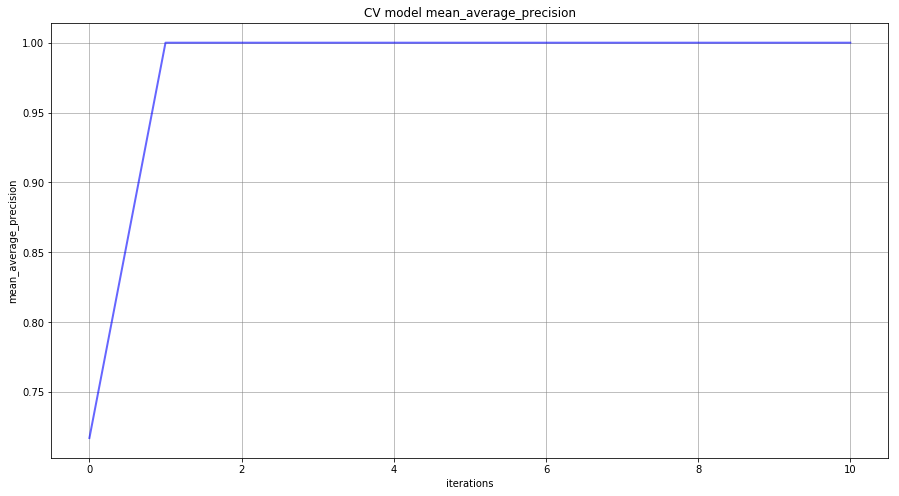

In [23]:
%matplotlib inline

plt.figure(figsize = (15,8))
plt.plot(metricsdf['mean_average_precision'], 'b-', lw=2, alpha=.6)
plt.xlabel('iterations', fontsize=10)
plt.ylabel('mean_average_precision', fontsize=10)
plt.title('CV model mean_average_precision', fontsize=12)
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.savefig('mean_average_precision.jpg', dpi=150) # Saving image in a jpg file
automl_image_run.log_image(name='mean_average_precision.jpg', plot=plt) # Logging the graph into the Azure ML experiment

plt.show()

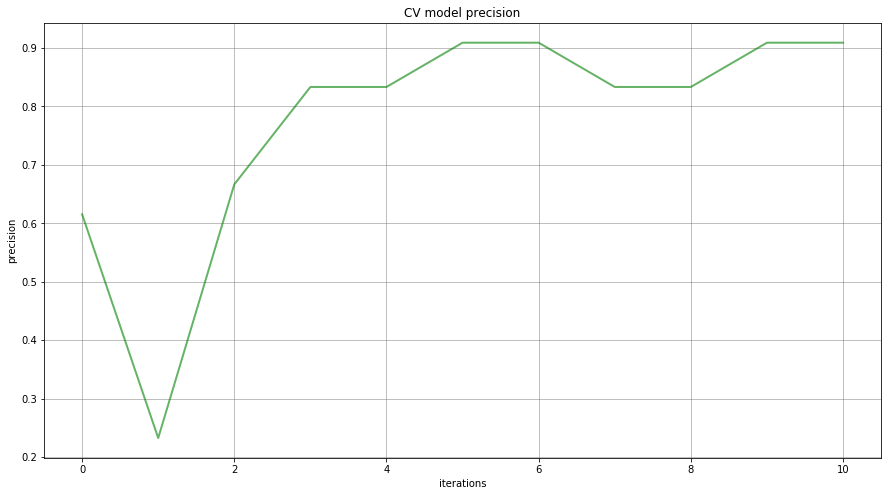

In [24]:
%matplotlib inline

plt.figure(figsize = (15,8))
plt.plot(metricsdf['precision'], 'g-', lw=2, alpha=.6)
plt.xlabel('iterations', fontsize=10)
plt.ylabel('precision', fontsize=10)
plt.title('CV model precision', fontsize=12)
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.savefig('precision.jpg', dpi=150) # Saving image in a jpg file
automl_image_run.log_image(name='precision.jpg', plot=plt) # Logging the graph into the Azure ML experiment

plt.show()

## Deploy model as a web service
Once you have your trained model, you can deploy the model on Azure. You can deploy your trained model as a web service on Azure Container Instances ([ACI](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-container-instance)) or Azure Kubernetes Service ([AKS](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-kubernetes-service)). Please note that ACI only supports small models under 1 GB in size. For testing larger models or for the high-scale production stage, we recommend using AKS.
In this tutorial, we will deploy the model as a web service in AKS.

You will need to first create an AKS compute cluster or use an existing AKS cluster. You can use either GPU or CPU VM SKUs for your deployment cluster

In [25]:
from azureml.core.compute import ComputeTarget, AksCompute
from azureml.exceptions import ComputeTargetException

aks_name = "cluster-aks-nc12"

t1 = datetime.datetime.now()

try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    print("Found existing compute target")

except ComputeTargetException:
    print("Creating a new compute target...")
    prov_config = AksCompute.provisioning_configuration(vm_size="STANDARD_D3_V2")
    aks_target = ComputeTarget.create(
        workspace=ws, name=aks_name, provisioning_configuration=prov_config
    )
    aks_target.wait_for_completion(show_output=True)

t2 = datetime.datetime.now()
print("\nTime:", t2 - t1)

Found existing compute target

Time: 0:00:00.132741


Next, you will need to define the [inference configuration](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#update-inference-configuration), that describes how to set up the web-service containing your model. You can use the scoring script and the environment from the training run in your inference config.

<b>Note:</b> To change the model's settings, open the downloaded scoring script and modify the model_settings variable <i>before</i> deploying the model.

In [26]:
from azureml.core.model import InferenceConfig

best_child_run.download_file(
    "outputs/scoring_file_v_1_0_0.py", output_file_path="score.py"
)
environment = best_child_run.get_environment()
inference_config = InferenceConfig(entry_script="score.py", environment=environment)

In [27]:
!ls score.py -ls

2 -rwxrwxrwx 1 root root 2000 Dec 10 15:34 score.py


In [28]:
with open(os.path.join('score.py'), 'r') as f:
    print(f.read())

# ---------------------------------------------------------
# Copyright (c) Microsoft Corporation. All rights reserved.
# ---------------------------------------------------------
import os
import tempfile
import logging

from azureml.contrib.services.aml_request import rawhttp
from azureml.automl.core.shared import logging_utilities
from azureml.contrib.services.aml_response import AMLResponse
from azureml.core.model import Model

from azureml.automl.dnn.vision.common.utils import _set_logging_parameters
from azureml.automl.dnn.vision.common.model_export_utils import load_model, run_inference
from azureml.automl.dnn.vision.common.logging_utils import get_logger

from azureml.automl.dnn.vision.object_detection.writers.score import _score_with_model

TASK_TYPE = 'image-instance-segmentation'
logger = get_logger('azureml.automl.core.scoring_script_images')


def init():
    global model

    # Set up logging
    _set_logging_parameters(TASK_TYPE, {})

    model_path = Model.get_model_pat

You can then deploy the model as an AKS web service.

In [33]:
# Deploy the model from the best run as an AKS web service
from azureml.core.webservice import AksWebservice
from azureml.core.model import Model

t1 = datetime.datetime.now()

aksmodelname = "automl-instanceseg-cansdetection"
aks_description="Instance Segmentation computer vision model to detect cans"

# Deploy the model from the best run as an AKS web service
aks_config = AksWebservice.deploy_configuration(
            autoscale_enabled=True, 
            cpu_cores=1, memory_gb=5, enable_app_insights=True, description=aks_description )

aks_service = Model.deploy(
    ws,
    models=[model],
    inference_config=inference_config,
    deployment_config=aks_config,
    deployment_target=aks_target,
    name=aksmodelname,
    overwrite=True,
)

aks_service.wait_for_deployment(show_output=True)

t2 = datetime.datetime.now()
print("\nTime:", t2 - t1)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-12-10 15:37:45+00:00 Creating Container Registry if not exists.
2021-12-10 15:37:46+00:00 Registering the environment.
2021-12-10 15:37:46+00:00 Use the existing image.
2021-12-10 15:37:48+00:00 Creating resources in AKS.
2021-12-10 15:37:49+00:00 Submitting deployment to compute.
2021-12-10 15:37:50+00:00 Checking the status of deployment automl-instanceseg-cansdetection..
2021-12-10 15:38:33+00:00 Checking the status of inference endpoint automl-instanceseg-cansdetection.
Succeeded
AKS service creation operation finished, operation "Succeeded"

Time: 0:00:58.834738


In [35]:
print("AKS service status:", aks_service.state)

AKS service status: Healthy


In [37]:
print("Computer Vision model endpoint:", aks_service.scoring_uri)
print("\nComputer Vision model endpoint properties:", aks_service.properties)

Computer Vision model endpoint: http://20.93.27.173:80/api/v1/service/automl-instanceseg-cansdetection/score

Computer Vision model endpoint properties: {'azureml.git.repository_uri': 'https://github.com/retkowsky/AutoMLforImages', 'mlflow.source.git.repoURL': 'https://github.com/retkowsky/AutoMLforImages', 'azureml.git.branch': 'main', 'mlflow.source.git.branch': 'main', 'azureml.git.commit': 'a987518ec8d17eb29d035a1bdaa5895246046dfb', 'mlflow.source.git.commit': 'a987518ec8d17eb29d035a1bdaa5895246046dfb', 'azureml.git.dirty': 'True', 'hasInferenceSchema': 'False', 'hasHttps': 'False'}


In [38]:
print(aks_service.get_logs())

2021-12-10T15:38:22,449117716+00:00 - iot-server/run 
2021-12-10T15:38:22,449170515+00:00 - rsyslog/run 
2021-12-10T15:38:22,449833208+00:00 - gunicorn/run 
Dynamic Python package installation is disabled.
Starting HTTP server
2021-12-10T15:38:22,450785097+00:00 - nginx/run 
EdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...
2021-12-10T15:38:22,521986281+00:00 - iot-server/finish 1 0
2021-12-10T15:38:22,523327266+00:00 - Exit code 1 is normal. Not restarting iot-server.
Starting gunicorn 20.1.0
Listening at: http://127.0.0.1:31311 (15)
Using worker: sync
worker timeout is set to 300
Booting worker with pid: 50
SPARK_HOME not set. Skipping PySpark Initialization.
generated new fontManager
Initializing logger
2021-12-10 15:38:27,984 | root | INFO | Starting up app insights client
logging socket was found. logging is available.
logging socket was found. logging is available.
2021-12-10 15:38:27,985 | root | INFO | Starting up request id generator
2021-12-10 15:38:2

## Test the deployed model

## Testing

In [39]:
sample_image = "tests/test1.jpg"
#sample_image = "tests/test2.jpg"
#sample_image = "tests/test3.jpg"
#sample_image = "tests/test4.jpg"
#sample_image = "tests/test5.jpg"

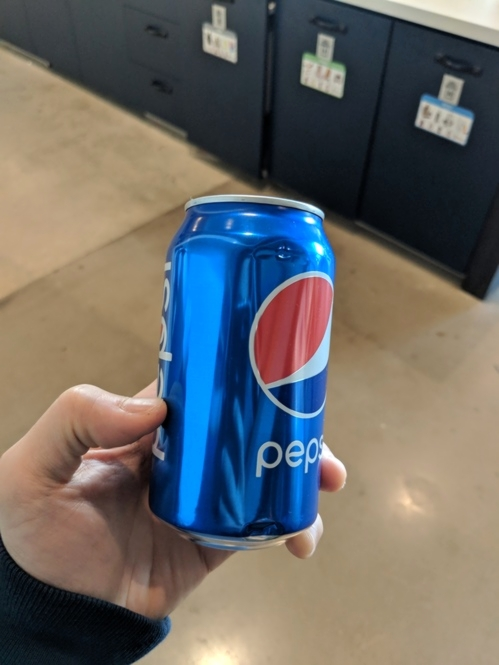

In [40]:
from IPython.display import Image
Image(filename=sample_image) 

In [41]:
scoring_uri = aks_service.scoring_uri
key, _ = aks_service.get_keys()

## Calling the model

In [42]:
t1 = datetime.datetime.now()
data = open(sample_image, "rb").read()
headers = {"Content-Type": "application/octet-stream"}
headers["Authorization"] = f"Bearer {key}"
resp = requests.post(scoring_uri, data, headers=headers)
t2 = datetime.datetime.now()
timediff = t2 - t1
inferencetime = timediff.seconds *1000 + timediff.microseconds
print("Inference time in sec. =", inferencetime/1000000)

Inference time in sec. = 0.484632


In [43]:
class RenderJSON(object):
    def __init__(self, json_data):
        if isinstance(json_data, dict):
            self.json_str = json.dumps(json_data)
        else:
            self.json_str = json_data
        self.uuid = str(uuid.uuid4())

    def _ipython_display_(self):
        display_html('<div id="{}" style="height: 600px; width:100%;"></div>'.format(self.uuid), raw=True)
        display_javascript("""
        require(["https://rawgit.com/caldwell/renderjson/master/renderjson.js"], function() {
        document.getElementById('%s').appendChild(renderjson(%s))
        });
        """ % (self.uuid, self.json_str), raw=True)

In [44]:
RenderJSON(resp.text)

In [45]:
minconfscore = 0.8
roundvalues = 4
colordots = 'blue'
colorback = 'cyan'
colorrect= 'lime'
colortext = 'red'
rectlinewidth = 5
markersize = 10
fontsize = 15

In [46]:
detections = json.loads(resp.text)
nlabel = 1

for detect in detections["boxes"]:
    if detect["score"] > minconfscore: # Min Value
        label = detect["label"]
        box = detect["box"]
        polygon = detect["polygon"]
        conf_score = detect["score"]
        print(nlabel, '. Detected:', label, 'with confidence =', conf_score, "Box:", box, '\n')
        #print("Polygon:", polygon, '\n')
        nlabel+=1

print(">> Results:", nlabel-1, "cans were detected.")

1 . Detected: can with confidence = 0.9996689558029175 Box: {'topX': 0.3113262939453125, 'topY': 0.2922928372073979, 'bottomX': 0.6758732096354166, 'bottomY': 0.8107065289130945} 

>> Results: 1 cans were detected.


Instance Segmentation Custom vision model predictions:

1 :  can : 155.3518 194.3747 181.9089 344.7451 | Confidence =  0.9997


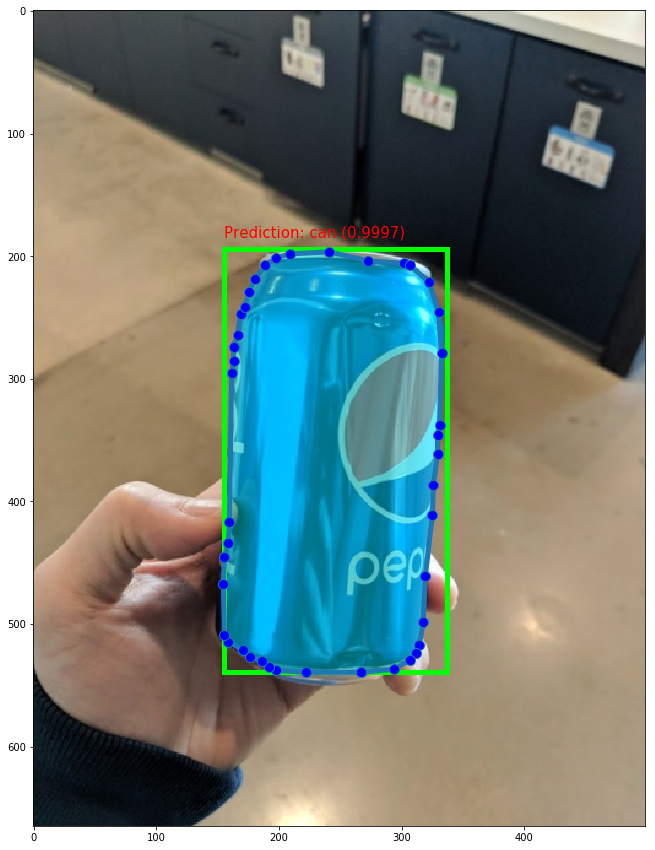

In [47]:
%matplotlib inline
from IPython.display import display_javascript, display_html, display
from matplotlib.lines import Line2D
from PIL import Image

IMAGE_SIZE = (18, 12)
plt.figure(figsize=IMAGE_SIZE)
img_np = mpimg.imread(sample_image)
img = Image.fromarray(img_np.astype("uint8"), "RGB")
x, y = img.size

fig, ax = plt.subplots(1, figsize=(18, 15)) # Dimensions
ax.imshow(img_np)

print("Instance Segmentation Custom vision model predictions:\n")
nblabel=1

detections = json.loads(resp.text)
for detect in detections["boxes"]:
    label = detect["label"]
    box = detect["box"]
    polygon = detect["polygon"]
    conf_score = detect["score"]
    
    if conf_score > minconfscore:
        ymin, xmin, ymax, xmax = (
            box["topY"],
            box["topX"],
            box["bottomY"],
            box["bottomX"],
        )
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        
        print(nblabel, ': ', 
              detect["label"], ':', 
              round(topleft_x, roundvalues), 
              round(topleft_y, roundvalues),                
              round(width, roundvalues), 
              round(height, roundvalues), 
              '| Confidence = ', round(conf_score, roundvalues) )
        
        rect = patches.Rectangle(
            (topleft_x, topleft_y),
            width,
            height,
            linewidth=rectlinewidth,
            edgecolor=colorrect,
            facecolor="none",
        )

        ax.add_patch(rect)
        labelmsg = 'Prediction: ' + label + ' (' + str(round(conf_score, roundvalues)) + ')'
        plt.text(topleft_x, topleft_y - 10, labelmsg, color=colortext, fontsize=fontsize)

        polygon_np = np.array(polygon[0])
        polygon_np = polygon_np.reshape(-1, 2)
        polygon_np[:, 0] *= x
        polygon_np[:, 1] *= y
        poly = patches.Polygon(polygon_np, True, facecolor=colorback, alpha=0.4)
        ax.add_patch(poly)
        
        poly_line = Line2D(
            polygon_np[:, 0],
            polygon_np[:, 1],
            linewidth=5,
            marker="o",
            markersize=markersize,
            markerfacecolor=colordots,
        )
        ax.add_line(poly_line)
        nblabel+=1
        
fig.savefig('tests/predictiontest.jpg', dpi=150) #Saving image
automl_image_run.log_image(name='tests/predictiontest.jpg', plot=plt) # Logging the graph into the Azure ML experiment

plt.show()

## Deleting

In [48]:
# Let's delete our Azure ML GPU compute cluster
compute_target.delete()

In [49]:
# Let's delete the service
#aks_service.delete()